# Simple state/space model for 2pp voting intention

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Load-2pp-data-and-prepare-for-analysis" data-toc-modified-id="Load-2pp-data-and-prepare-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load 2pp data and prepare for analysis</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The model</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#House-effects" data-toc-modified-id="House-effects-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>House effects</a></span></li><li><span><a href="#2pp-Voting-Intention" data-toc-modified-id="2pp-Voting-Intention-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>2pp Voting Intention</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')

# system imports
import pathlib
#import json

Stan version: 3.3.0
ArviZ version: 0.11.4


In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# path to the model data
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

SOURCE = 'Polling data from Wikipedia'

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

## Load 2pp data and prepare for analysis

In [5]:
# read in 2pp data; remind me, what are the column names ...
tpp = pd.read_csv(f'{DATA_DIR}two_party_preferred.csv', parse_dates=['Mean Date'], index_col=0)
tpp.columns

Index(['2pp vote L/NP', '2pp vote ALP', 'Date', 'Mean Date', 'Brand',
       'Interview mode', 'Sample size', '2pp Vote L/NP LOWESS'],
      dtype='object')

In [6]:
# What polling firms are we working with ...
# and how many polls has each collected
tpp['Brand'].value_counts()

Newspoll-YouGov    38
Essential          31
Roy Morgan         17
Name: Brand, dtype: int64

In [7]:
# Encode polling firms to an integer starting from 1
tpp['Brand'] = tpp['Brand'].astype('category')
tpp['House'] = tpp['Brand'].cat.codes + 1
tpp['House'].value_counts()

2    38
1    31
3    17
Name: House, dtype: int64

In [8]:
# Create a map of firm number back to firm name
# Not the most efficient way to do this ...
brand_map = {x+1: y for x, y in zip(tpp['Brand'].cat.codes, tpp['Brand'])}
brand_map

{2: 'Newspoll-YouGov', 3: 'Roy Morgan', 1: 'Essential'}

In [9]:
# Change dates to days from the start ...
# The first day is 1
first_day = tpp['Mean Date'].min()
tpp['Day'] = (
    ((tpp['Mean Date'] - first_day) 
     / pd.Timedelta(days=1)).astype(int) 
    + 1
)

# Total number of days to model ...
tpp['Day'].max()

819

In [10]:
# Number of polls
len(tpp)

86

## The model

In [11]:
tpp_model_code = """

// STAN: Two-Party Preferred (TPP) Vote Intention Model 

data {
    // data size
    int<lower=1> n_polls;
    int<lower=1> n_days;
    int<lower=1> n_houses;
    
    // assumed standard deviation for all polls
    real<lower=0> pseudoSampleSigma;
    
    // poll data
    vector<lower=0,upper=1>[n_polls] y; // TPP vote share
    int<lower=1> house[n_polls];
    int<lower=1> day[n_polls];
}

transformed data {
    real sigma = 0.0015;
}

parameters {
    vector[n_days] hidden_vote_share; 
    vector[n_houses] pHouseEffects;
}

transformed parameters {
    // -- sum to zero constraint on house effects
    vector[n_houses] houseEffect;
    houseEffect[1:n_houses] = pHouseEffects[1:n_houses] - mean(pHouseEffects[1:n_houses]);
}

model {
    // -- temporal model [this is the hidden state-space model]
    hidden_vote_share[1] ~ normal(0.5, 0.15); // PRIOR
    hidden_vote_share[2:n_days] ~ normal(hidden_vote_share[1:(n_days-1)], sigma);
    
    // -- house effects model
    pHouseEffects ~ normal(0, 0.08); // PRIOR 

    // -- observed data / measurement model
    y ~ normal(houseEffect[house] + hidden_vote_share[day], pseudoSampleSigma);
}

"""

In [12]:
sampleSize = 1000 # treat all polls as being of this size
pseudoSampleSigma = np.sqrt((0.5 * 0.5) / sampleSize) 


tpp_model_data = {
    # Remember: stan numbers arrays from 1 to N
    # Note: JSON cannot serialise pandas or numpy datatypes
    
    'n_polls': len(tpp),
    'n_days': int(tpp['Day'].max()),
    'n_houses': int(tpp['House'].max()),

    'pseudoSampleSigma': pseudoSampleSigma,
    
    'y': (tpp['2pp vote L/NP'] / 100.0).to_list(),
    'house': tpp['House'].to_list(),
    'day': tpp['Day'].to_list(),
}


In [13]:
posterior = stan.build(tpp_model_code, data=tpp_model_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_xf0bisek/model_2iiccniv.stan', line 41, column 30: Argument 0.08 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_xf0bisek/model_2iiccniv.stan', line 21, column 17: Argument 0.0015 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [14]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/8000)
Sampling:  45% (3600/8000

## Diagnostics

In [15]:
#az.from_pystan(fit)

In [16]:
# Estimated Bayesian Fraction of Missing Information ...
# Good if close to one; bad if close to zero ...
bfmi = az.bfmi(fit)
if (bfmi <= 0.5).any():
    print('Note: the BFMI could be problematic')
    print(bfmi)

In [26]:
# R-hat chain convergence diagnostic
# ESS - effective sample size (used to be n_eff)
RHAT_THRESHOLD = 1.05
ESS_THRESHOLD = 1000
rhat = az.rhat(fit)
ess = az.ess(fit)
for var in ['houseEffect', 'hidden_vote_share']:
    if (rhat[var] > RHAT_THRESHOLD).any():
        print(f'Check {var} - chain convergence')
    if (ess[var] < ESS_THRESHOLD).any():
        print(f'Check {var} - effective sample size')

array([[<AxesSubplot:title={'center':'houseEffect'}>,
        <AxesSubplot:title={'center':'houseEffect'}>]], dtype=object)

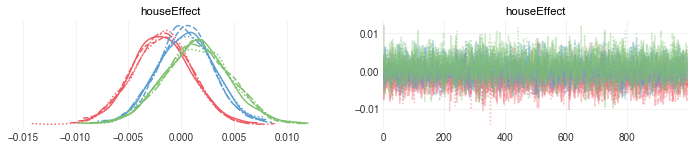

In [18]:
az.plot_trace(fit, var_names=['houseEffect'])

## Results

In [19]:
results_df = fit.to_frame()

In [20]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW = 'low'
HIGH = 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


In [21]:
def plot_wrap(fig, ax, title):
    ax.set_title(title)
    fig.tight_layout(pad=1.1)
    fig.text(0.005, 0.005, 
             'Note: house effects sum to zero', 
             ha='left', va='bottom', 
             c='#999999', style='italic', fontsize=8)
    fig.text(0.995, 0.005, SOURCE, ha='right', va='bottom', 
             c='#999999', style='italic', fontsize=8)
    fig.savefig(CHART_DIR+title+'.png', dpi=300)
    plt.show()
    plt.close()

### House effects

In [22]:
# Get the house effects data
house_effects = results_df[results_df.columns[results_df.columns.str.contains('houseEffect')]]
house_effects = house_effects * 100 # percent
house_effects.columns = (
    house_effects.columns
    .str.extract(r'([\d]+)$')
    .pipe(lambda x: x[x.columns[0]])
    .astype(int)
    .map(brand_map)
)
house_effects = house_effects.quantile(quants)

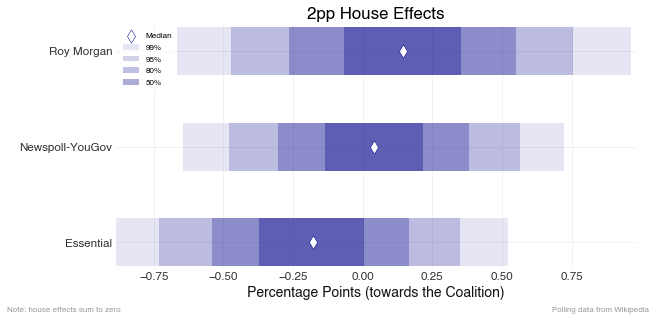

In [23]:
# Plot the house effects data
fig, ax = plt.subplots()
ax.margins(0.01)

for i, house in enumerate(house_effects.columns):
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = house_effects.loc[low, house]
        width = house_effects.loc[high, house] - lowpoint
        label = x if i == 0 else None
        ax.barh(y=house, left=lowpoint, width=width, 
                height=0.5, color='darkblue', alpha=alpha,
                label=label)
        alpha += 0.075

ax.scatter(y=range(len(house_effects.columns)), 
           x=house_effects.loc[0.500],
           marker='d', facecolor='white',
           edgecolor='darkblue', 
           linewidth=0.5, zorder=2,
           label='Median', s=90)

ax.legend(loc='best')
ax.set_xlabel('Percentage Points (towards the Coalition)')

plot_wrap(fig, ax, '2pp House Effects')

### 2pp Voting Intention

In [24]:
# Get the daily hidden vote share data
hvs = (
    results_df[
        results_df.columns[
            results_df.columns.str.contains('hidden_vote_share')
        ]
    ]
)
hvs = hvs * 100 # percent
hvs.columns = pd.date_range(start=first_day, freq='D', 
                            periods=len(hvs.columns))
hvs = hvs.quantile(quants)

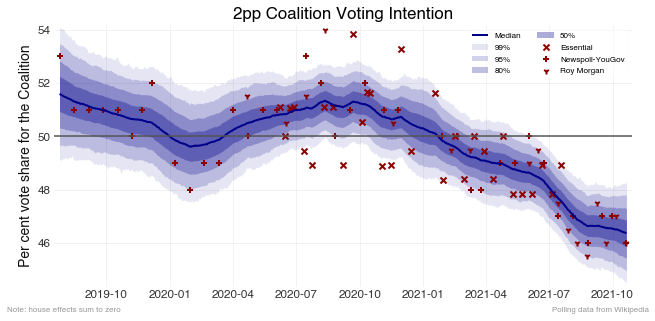

In [25]:
# Plot the daily hidden vote share data
fig, ax = plt.subplots()
ax.margins(0.01)
alpha = 0.1
for x, y in ranges.iterrows():
    low = y[0]
    high = y[1]
    lowpoint = hvs.loc[low]
    highpoint = hvs.loc[high]
    ax.fill_between(x=lowpoint.index, y1=lowpoint, y2=highpoint,
                    color='darkblue', alpha = alpha,label=x,)
    alpha += 0.075
    
ax.plot(hvs.columns, hvs.loc[0.500], 
        color='darkblue', lw=2, label='Median')

ax.axhline(y=50, c='#555555', lw=1.5)

brand_col = 'Brand'
markers = ['x', '+', '1', '2', '3', '4']
for i, brand in enumerate(sorted(tpp[brand_col].unique())):
    subset = tpp.loc[tpp[brand_col] == brand]
    if not len(subset):
        continue # ignore empty subsets
    ax.scatter(subset['Mean Date'], subset['2pp vote L/NP'], 
               marker=markers[i], label=brand,
               color='darkred')

ax.set_ylabel('Per cent vote share for the Coalition')
ax.legend(loc='best', ncol=2)
    
plot_wrap(fig, ax, '2pp Coalition Voting Intention')